In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.style.use("dark_background")
%config InlineBackend.figure_format='retina'



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## 0. Data Preparation

In [2]:
year = "2019"
data_dir = u"../Data/"
bin_sample_path = f"{data_dir}binSamples/"
fill_sample_path = f"{data_dir}fillSamples/"
result_path = f"{data_dir}inner_results/"

In [3]:
year = "2019"
month_int = 1
bin_sample_path = f"{data_dir}binSamples/"
month = '%02d' % month_int
filename = "bin%s%s.csv" % (year, month)
bin_sample_df = pd.read_csv(bin_sample_path+filename)

Column descriptors:

date - YYYY-MM-DD for the given bin.

time - Time at start of bin.

stock - Stock ticker symbol for the row's binned data.

trade - Signed net number of shares traded over the bin window.

orderFlow - Signed net number of shares added to the book via limit orders (LOs) during the bin window.

hidden - Total number of shares added through hidden LOs during the bin window. Hidden = unknown direction.

auction - Signed volume traded in auctions.

mid - Midprice at the start of the bin window. Defined as arithmetic mean of best bid and best ask prices.

midfin - Midprice at the end of the bin window. Defined as arithmetic mean of best bid and best ask prices.

spread - Spread at start of bin window defined as (ask - bid) / 2.

effSpread - Effective spread at start of bin window defined as average spread paid per trade.

lobImb - Order book imbalance at start of bin window, unnormalized, defined as the ratio of askVolume to bidVolume.

efflobImb - Order book imbalance at start of bin window, defined as average lobImb before each trade.

totVol - Total unsigned number of shares traded in either direction during bin window.

trdVolq - Total unsigned number of shares added to book (at any level) in LOs in either direction during bin window.

ofiLiq - Total unsigned number of shares traded (at any level) in LOs in either direction during bin window.

depth - Sum of volumes at best bid and best ask at start of bin window.

nbEvents - Count of book updates during bin window (LOs or MOs).

nbHidden - Count of hidden LOs filled during bin window.

nbTrades - Count of MOs (or crossed LOs) trade executions during the bin window.


## 1. Daily Price Volatility and ADV

Calculate a 20-day rolling average on all months

In [4]:
list_by_month = []
for month_int in range(1, 13):
    bin_sample_path = f"{data_dir}binSamples/"
    month = '%02d' % month_int
    filename = "bin%s%s.csv" % (year, month)
    bin_sample_df = pd.read_csv(bin_sample_path+filename)
    
    price_df = bin_sample_df[["date", "time", "stock", "midEnd"]]\
                .pivot(index=["stock", "date"], columns="time")\
                .bfill(axis=1).ffill(axis=1)

    traded_volume_df = bin_sample_df[["stock", "date", "trade", "time"]].\
                    pivot(index=["stock", "date"], columns="time", values="trade").\
                    fillna(0)
    
    monthly_df = pd.DataFrame({
        "price volatility": price_df.pct_change(axis=1).std(axis=1),
        "ave daily volume": traded_volume_df.abs().sum(axis=1)})
    
    list_by_month.append(monthly_df)
    
all_month_df = pd.concat(list_by_month)

In [5]:
mean_info = all_month_df.groupby('stock').rolling(20).mean()
mean_info.index = mean_info.index.droplevel(0)
mean_info = mean_info.reset_index()
mean_info = mean_info.set_index(["stock", "date"])

## 2. Intraday Impact by OW Model (DODGY!)

### The baseline model

The equation

$$ I_{t+\delta t} - I_t = -\beta I_t \delta t + \lambda \sigma \frac{q_t}{ADV} $$

is an EMA on $\lambda \sigma \frac{q_t}{ADV}$.

$\sigma$, $ADV$ can be estimated from historical data or can come from predictive models such as risk and volume models. Therefore, $\beta$, $\lambda$ are the only parameters left to estimate.

*References*

*Obizhaeva and Wang (2013), Chen, Horst, and Hai Tran (2019).*

### The nonlinear Propagator model

The equation

$$ I_{t+\delta t} - I_t = -\beta I_t \delta t + \lambda \sigma \cdot \text{sign}(q_t) \sqrt{\frac{|q_t|}{ADV}} $$

is an EMA on $\lambda \sigma \text{sign}(q_t) \sqrt{\frac{|q_t|}{ADV}}$.

This model is nonlinear in $q$ but linear in $\lambda$. Therefore, one still fits the model via linear regression on the non-linear features.

*References*

*Bouchaud et al. (2004), Buseti and Lillo (2012).*


### A naive implementation (with `df.ewm`)

In [6]:
month_int = 2
bin_sample_path = f"{data_dir}binSamples/"
month = '%02d' % month_int
filename = "bin%s%s.csv" % (year, month)
bin_sample_df = pd.read_csv(bin_sample_path+filename)

price_df = bin_sample_df[["date", "time", "stock", "midEnd"]]\
            .pivot(index=["stock", "date"], columns="time")\
            .bfill(axis=1).ffill(axis=1)

traded_volume_df = bin_sample_df[["stock", "date", "trade", "time"]].\
                pivot(index=["stock", "date"], columns="time", values="trade").\
                fillna(0)

stock = "AAPL"
date = "2019-02-21"
v = traded_volume_df.loc[stock, date]

`x.ewm` when `adjust=False` returns `y` such that:
$$
y_0 = x_0 \\
y_t = (1 - \alpha)y_{t-1} + \alpha x_t
$$

First one needs to find $\alpha$, by standard ODE calculations $\alpha = 1 - \exp(-b * \delta t)$; as half-life controls $\beta$ by $\frac{1}{2} I_0 = I_0 \exp(-\beta h)$ from $I_t = I_0 \exp(-\beta t)$, one obtains $\beta = \log(2) / h$.

The solution of 
$$ I_{t+\delta t} - I_t = -\beta I_t \delta t + \lambda \sigma \frac{q_t}{ADV} $$
can then be considered as a moving average of $\sigma \frac{q_t}{ADV}$.

In [7]:
half_life = 3600
time_unit = 10
beta = np.log(2) / half_life
decay_factor = np.exp(-beta * time_unit)
alpha = 1 - decay_factor
ADV = 1.0
vol = 0.2

v.iloc[1:] /= alpha
v *= vol
v /= ADV
ewm_v = v.ewm(alpha=alpha, adjust=False).mean()


<Axes: title={'center': 'Price Impact $I$'}, xlabel='time'>

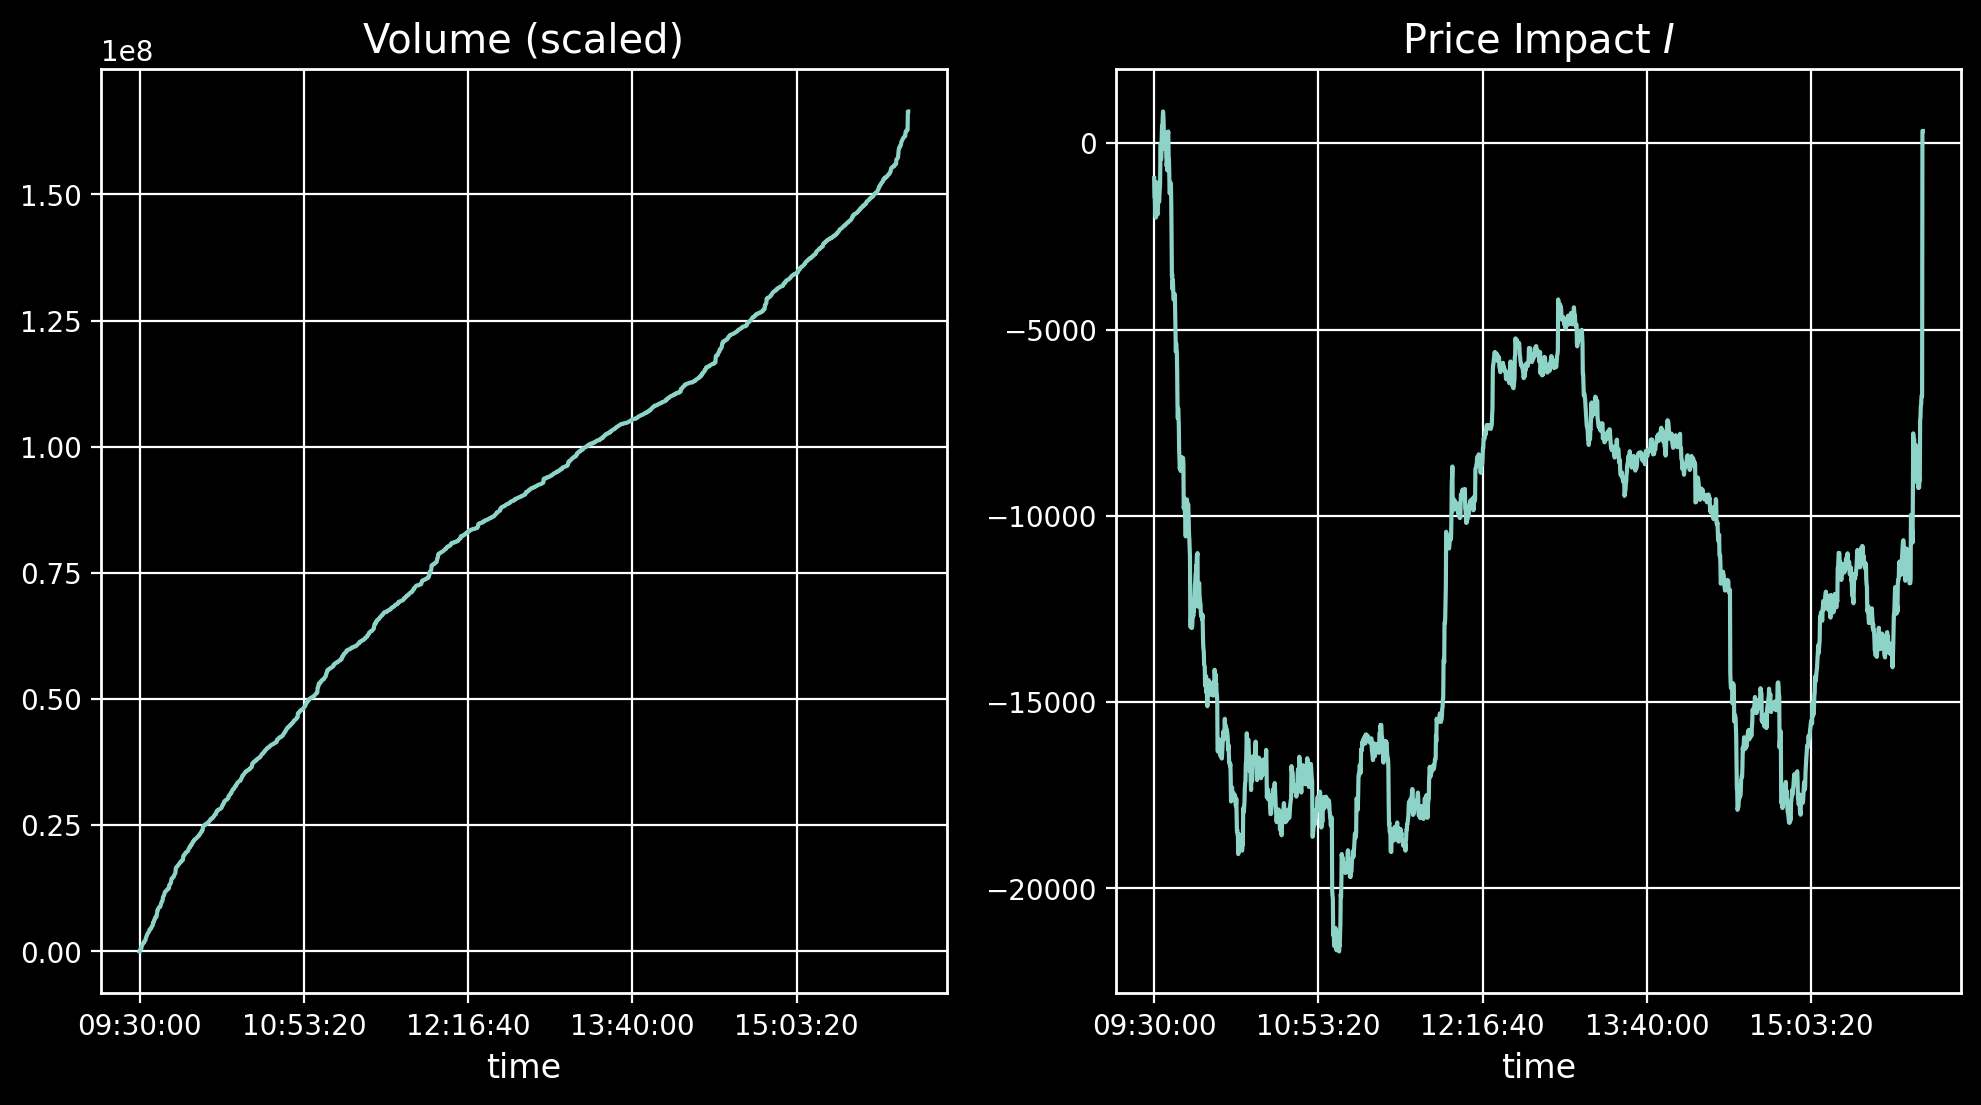

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
v.abs().cumsum().plot(ax=ax[0], title="Volume (scaled)")
ewm_v.plot(ax=ax[1], title="Price Impact $I$")

### Gerneralised implementation (space kernels)

In [9]:
def impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type):
    # space kernels
    space_kernels = {
        "linear": lambda x: x,
        "sqrt": lambda x: np.sign(x) * np.sqrt(np.abs(x)),
    }

    beta = np.log(2) / half_life
    time_unit = 10  # 10 seconds
    decay_factor = np.exp(-beta * time_unit)
    pre_ewm = traded_volume_df
    pre_ewm = pre_ewm.divide(monthly_scaling_factor["ave daily volume"], axis="rows")
    pre_ewm = space_kernels[model_type](pre_ewm)
    pre_ewm = pre_ewm.multiply(monthly_scaling_factor["price volatility"], axis="rows")

    pre_ewm.iloc[:, 1:] /= (1 - decay_factor)
    cum_impact = pre_ewm.ewm(alpha=1-decay_factor, adjust=False, axis="columns").mean()  # Across columns
    return cum_impact

In [13]:
half_life = 3600

cum_impact = impact_state(traded_volume_df, mean_info.loc[traded_volume_df.index], half_life, "linear")
# cum_impact.diff(1, axis="columns")
cum_impact

/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_72905/3760806265.py:17: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  cum_impact = pre_ewm.ewm(alpha=1-decay_factor, adjust=False, axis="columns").mean()  # Across columns


time                  09:30:00      09:30:10      09:30:20      09:30:30  \
stock date                                                                 
A     2019-02-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-04  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-05  0.000000e+00  0.000000e+00 -1.512828e-09 -1.509918e-09   
      2019-02-06  1.461321e-07  1.458510e-07  1.455705e-07  1.452905e-07   
      2019-02-07  0.000000e+00  0.000000e+00  0.000000e+00 -1.395284e-07   
...                        ...           ...           ...           ...   
ARE   2019-02-22  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-25  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-26  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-27  0.000000e+00  0.000000e+00  2.915215e-07  4.861999e-07   
      2019-02-28  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

time                  09:30:40      09:30:50      09:31:00      09:31:10  \
stock date                                                                 
A     2019-02-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-04  0.000000e+00  0.000000e+00  0.000000e+00  3.034668e-07   
      2019-02-05 -1.507014e-09 -1.504115e-09 -1.501222e-09 -1.498334e-09   
      2019-02-06  1.450110e-07  1.447321e-07  1.444537e-07  1.441758e-07   
      2019-02-07 -1.392600e-07 -1.389921e-07 -1.387248e-07 -1.384579e-07   
...                        ...           ...           ...           ...   
ARE   2019-02-22  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-25  1.408817e-07  1.406107e-07  1.403402e-07  1.400703e-07   
      2019-02-26  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-02-27  4.852647e-07  4.843312e-07  4.833996e-07  4.824697e-07   
      2019-02-28  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

time                  09:31:20      09:31:30  ...  15:58:30  15:58:40  \
stock date                                    ...                       
A     2019-02-01  0.000000e+00  0.000000e+00  ... -0.000010 -0.000009   
      2019-02-04  3.028830e-07  3.023004e-07  ... -0.000013 -0.000013   
      2019-02-05 -1.495452e-09  1.363571e-08  ... -0.000007 -0.000007   
      2019-02-06  1.438985e-07  4.358860e-07  ... -0.000027 -0.000027   
      2019-02-07 -1.381916e-07 -1.379258e-07  ...  0.000002  0.000003   
...                        ...           ...  ...       ...       ...   
ARE   2019-02-22  0.000000e+00  0.000000e+00  ...  0.000002  0.000001   
      2019-02-25  1.398008e-07  1.395319e-07  ...  0.000004  0.000004   
      2019-02-26  0.000000e+00  0.000000e+00  ... -0.000033 -0.000033   
      2019-02-27  4.815417e-07  4.806154e-07  ... -0.000011 -0.000012   
      2019-02-28  0.000000e+00  0.000000e+00  ... -0.000015 -0.000016   

time              15:58:50  15:59:00  15:59:10      15:59:20      15:59:30  \
stock date                                                                   
A     2019-02-01 -0.000009 -0.000009 -0.000009 -9.259571e-06 -9.241760e-06   
      2019-02-04 -0.000014 -0.000012 -0.000014 -1.385884e-05 -1.428738e-05   
      2019-02-05 -0.000006 -0.000007 -0.000007 -6.727636e-06 -7.229057e-06   
      2019-02-06 -0.000027 -0.000027 -0.000028 -2.826796e-05 -3.196480e-05   
      2019-02-07  0.000004  0.000004  0.000005  5.552012e-06  5.401804e-06   
...                    ...       ...       ...           ...           ...   
ARE   2019-02-22  0.000001  0.000001  0.000001  9.557941e-07  9.539556e-07   
      2019-02-25  0.000005  0.000004  0.000004  4.387730e-06  3.438200e-06   
      2019-02-26 -0.000034 -0.000034 -0.000034 -3.499173e-05 -3.451090e-05   
      2019-02-27 -0.000013 -0.000015 -0.000015 -1.522256e-05 -1.546073e-05   
      2019-02-28 -0.000017 -0.000017 -0.000018 -1.749229e-05 -1.754452e-05   

time              15:59:40  15:59:50  16:00:00  
stock da

## 3. Slippage analysis

<Axes: >

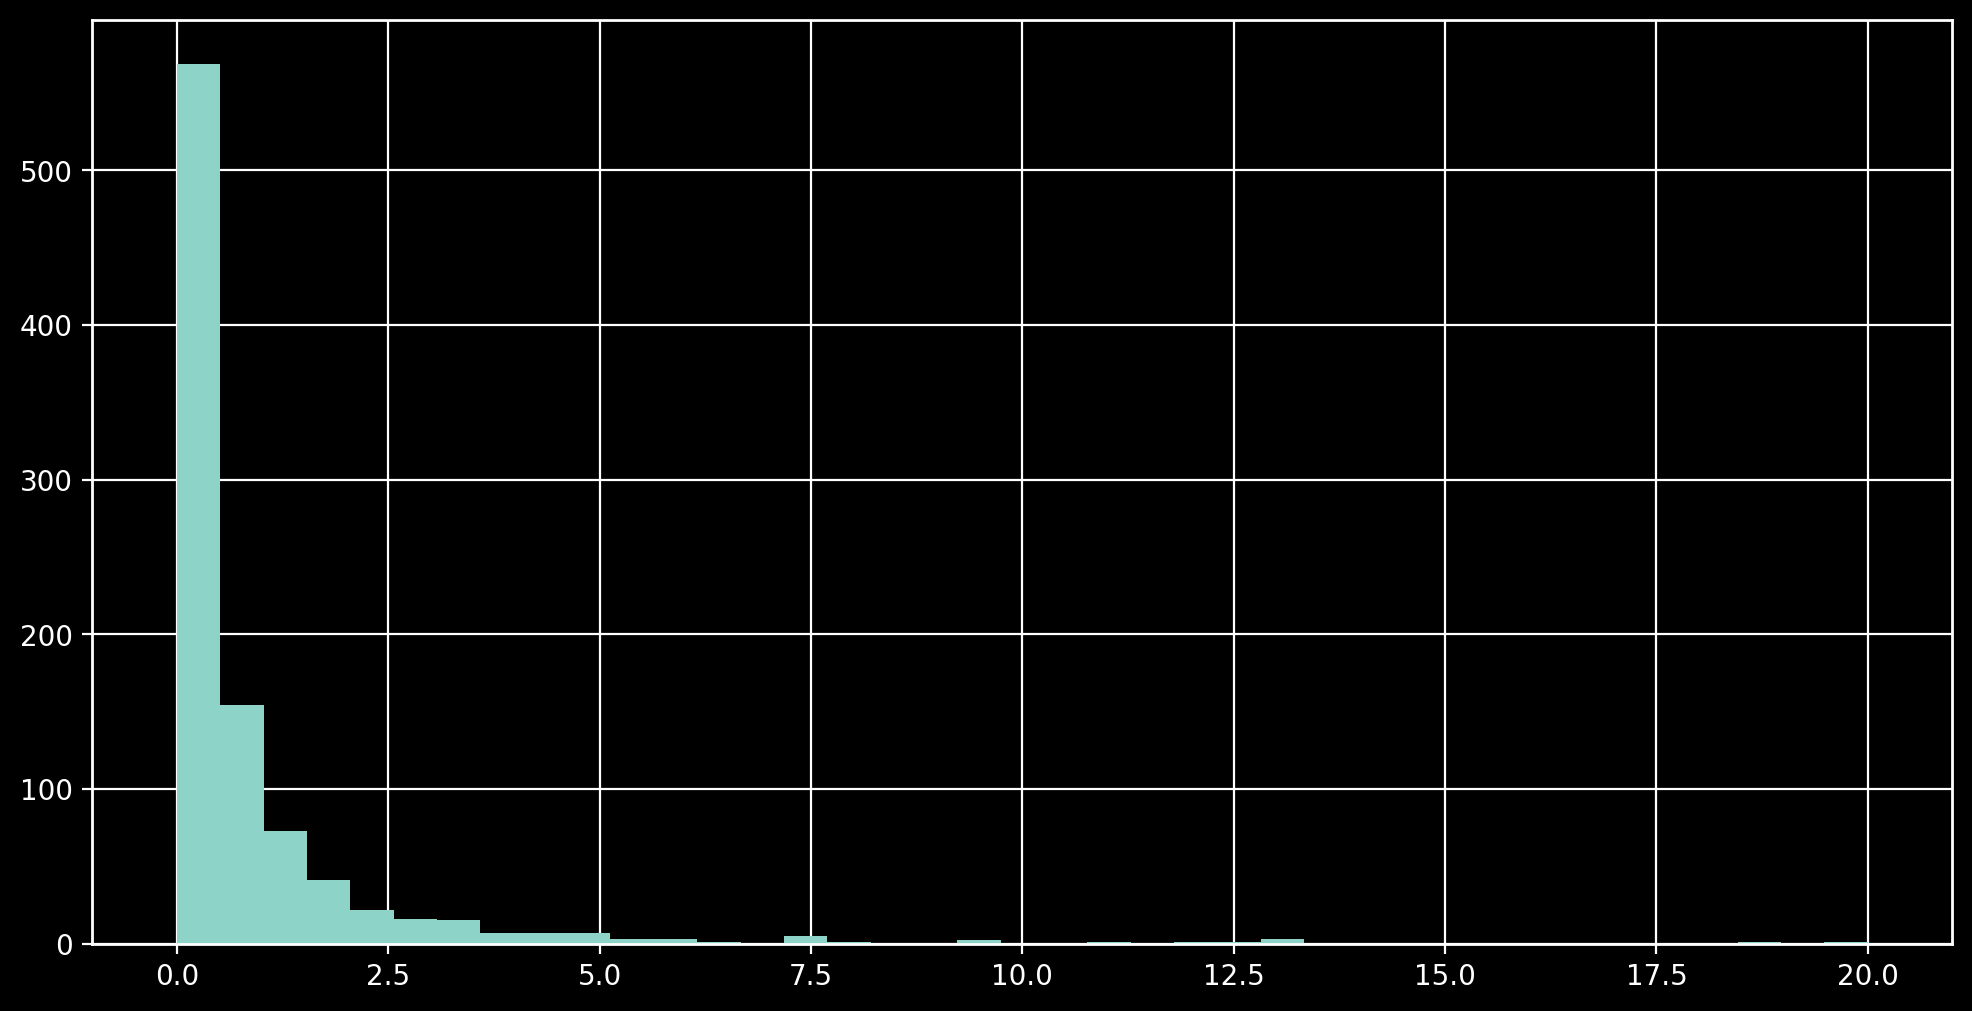

In [11]:
# Apply shift so that the slippage is calculated on the impact and
# the volume traded in the previous time unit
impact_slippage = (cum_impact * traded_volume_df.shift(1, axis=1)).sum(axis=1)
impact_slippage.hist(bins=np.linspace(0, 20, 40), figsize=(12, 6))

count       950.000000
mean        545.275964
std        4893.638517
min       -6236.298488
25%         -46.728809
50%          46.135689
75%         240.151411
max      126166.936129
dtype: float64

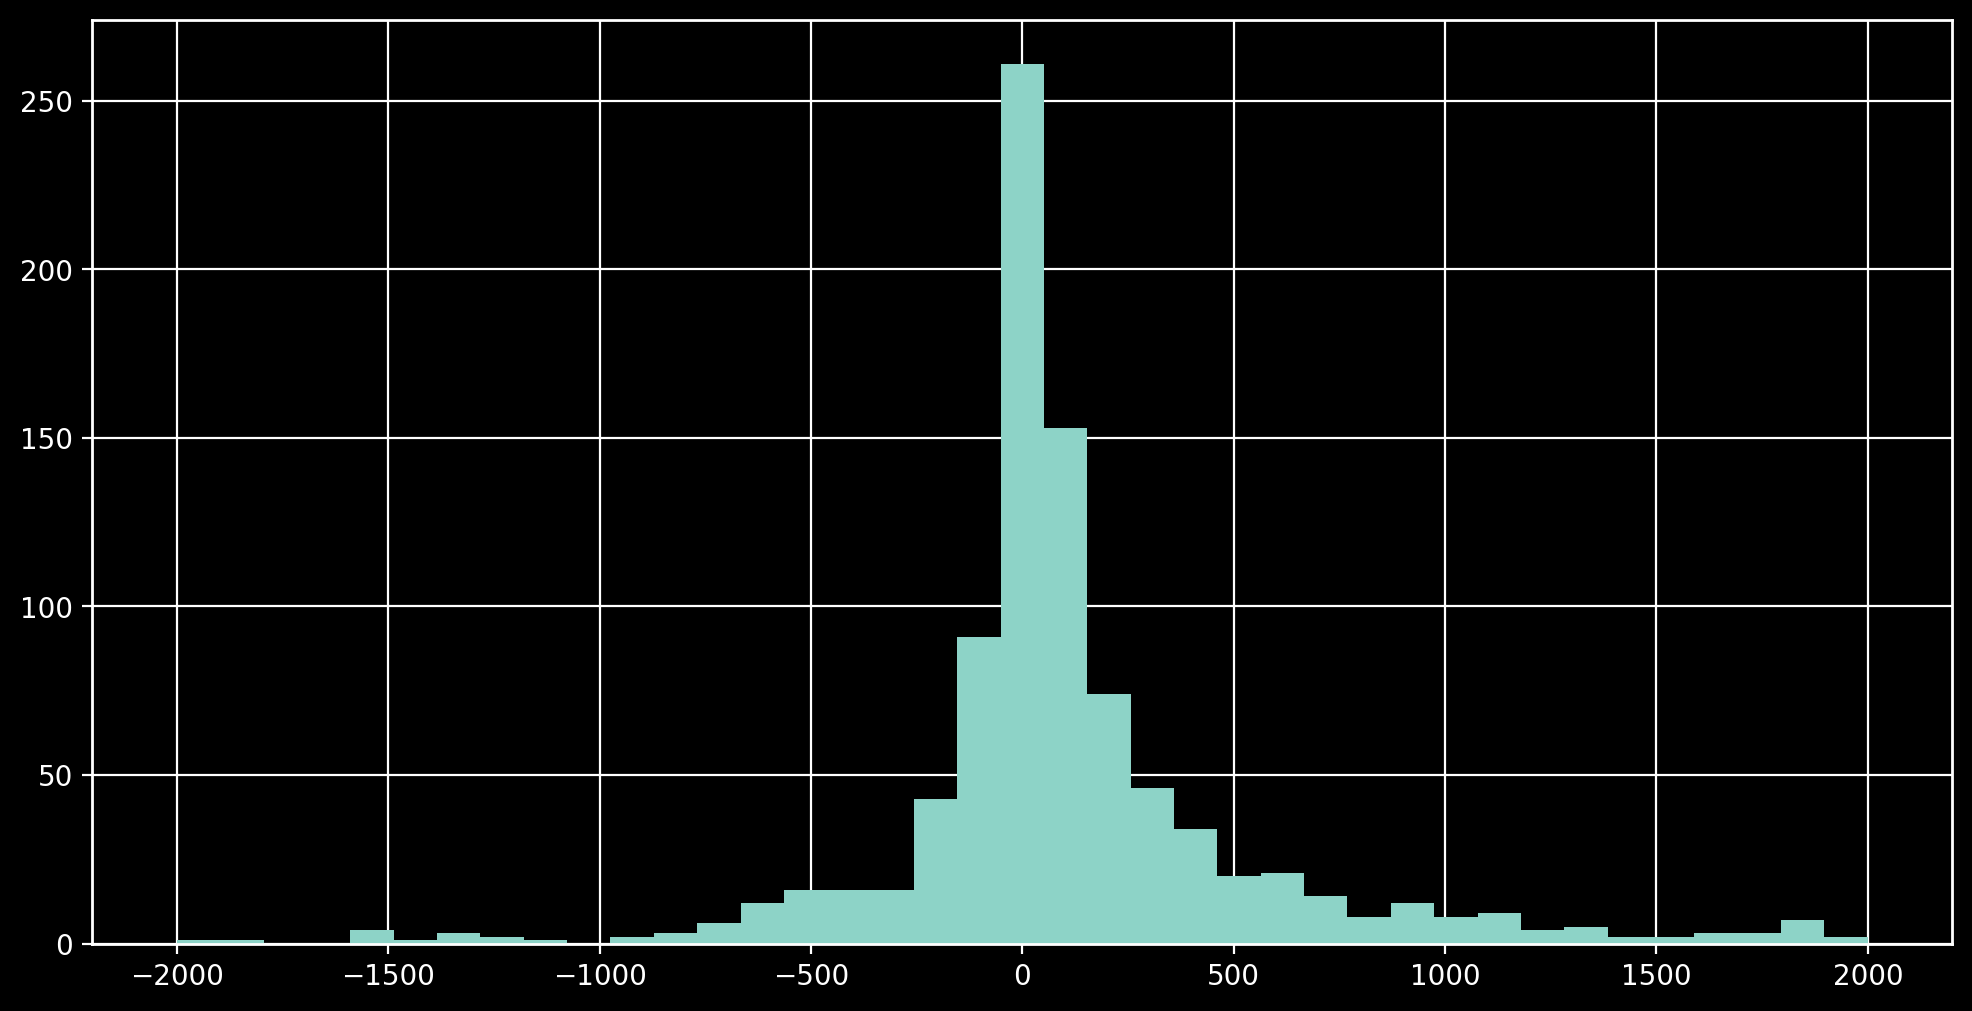

In [12]:
return_df = price_df.divide(price_df.iloc[:, 0], axis=0) - 1
alpha_slippage = (return_df * traded_volume_df.shift(1, axis=1)).sum(axis=1)
alpha_slippage.hist(bins=np.linspace(-2000, 2000, 40), figsize=(12, 6))
alpha_slippage.describe()